# CNN Classification of Mel Spectrograms

Tried and follow
https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

In [1]:
# For Colab only
from google.colab import drive
drive.mount('content/') # /content/drive/MyDrive/bird-songs

Mounted at content/


## Training a model

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

# for reading and displaying images
from skimage.io import imread
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import precision_score, recall_score, f1_score

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data.dataloader import DataLoader, Dataset


In [2]:
# Check whether google drive mounted
path = '/content/content/MyDrive/bird-songs'
if os.path.isdir(path) == True:
    run_on_colab = True
else:
    run_on_colab = False



if run_on_colab ==True:
    features = pd.read_csv('/content/content/MyDrive/bird-songs/features_filtered.csv', header=None, encoding='latin')
else:
    features = pd.read_csv('features_filtered.csv', encoding='latin')
features.head()

,id,gen,sp,ssp,en,cnt,loc,type,q,length,bird-seen,file,category
0,564895,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lyons Township (near Willow Springs), Cook Co...","adult, sex uncertain, song",no score,0:16,no,//www.xeno-canto.org/564895/download,song
1,545775,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Valley Forge National Historical Park, Montgom...",call,no score,0:17,yes,//www.xeno-canto.org/545775/download,call
2,540857,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:32,unknown,//www.xeno-canto.org/540857/download,song
3,540855,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:52,unknown,//www.xeno-canto.org/540855/download,song
4,487506,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lake Artemesia Natural Area, Prince George's C...",song,no score,0:25,yes,//www.xeno-canto.org/487506/download,song


In [4]:
features['path'] = features.apply(lambda row: f'images/mel_spectrograms_8sec/{str(row.id)}.jpg', axis=1)
features.head()

,id,gen,sp,ssp,en,cnt,loc,type,q,length,bird-seen,file,category,path
0,564895,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lyons Township (near Willow Springs), Cook Co...","adult, sex uncertain, song",no score,0:16,no,//www.xeno-canto.org/564895/download,song,images/mel_spectrograms_8sec/564895.jpg
1,545775,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Valley Forge National Historical Park, Montgom...",call,no score,0:17,yes,//www.xeno-canto.org/545775/download,call,images/mel_spectrograms_8sec/545775.jpg
2,540857,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:32,unknown,//www.xeno-canto.org/540857/download,song,images/mel_spectrograms_8sec/540857.jpg
3,540855,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:52,unknown,//www.xeno-canto.org/540855/download,song,images/mel_spectrograms_8sec/540855.jpg
4,487506,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lake Artemesia Natural Area, Prince George's C...",song,no score,0:25,yes,//www.xeno-canto.org/487506/download,song,images/mel_spectrograms_8sec/487506.jpg


In [3]:
def label_vectors(row):
    name_category = [specie_labels[row.en], category_labels[row.category]]
    label_vector = np.zeros(8)
    for idx in name_category:
        label_vector[idx] = 1
    return label_vector

# These are the top species we selected for our analysis
selected_species = ['Red-winged Blackbird', 
                    'Common Yellowthroat', 
                    'Northern Cardinal', 
                    'Carolina Wren', 
                    'Red Crossbill', 
                    'Spotted Towhee']
# We only need the id and the labels for our CNN.
dataset = features[features.en.isin(selected_species)][['id', 'en', 'category']]
# Now we need to change our labels into integers as torch does not support string format for labels.
specie_labels = {"Red-winged Blackbird": 0, 'Common Yellowthroat': 1, 'Northern Cardinal': 2, 'Carolina Wren': 3,
          'Red Crossbill': 4, 'Spotted Towhee': 5}
category_labels = {"song": 6, "call": 7}
dataset['label'] = dataset.apply(lambda row: label_vectors(row), axis=1)
dataset.drop(['en', 'category'], axis=1, inplace=True)

In [4]:
def load_images(dataset, path):
    img_df = []
    for img_name in tqdm(dataset['id']):
        # defining the image path
        if run_on_colab == True:
            image_path = f'/content/content/MyDrive/bird-songs/images/{path}/' + str(img_name) + '.jpg' 
        else:
            image_path = f'images/{path}/' + str(img_name) + '.jpg'
        # reading the image
        img = imread(image_path, as_gray=True)
         # normalizing the pixel values
        img = 2 * img - 1
        # converting the type of pixel to float 32
        img = img.astype('float32')
        # appending the image into the list
        img_df.append(img)
    
    # converting the list to numpy array
    return np.array(img_df)

## CNN - 8-second clips

If you have compatible GPU technology on your computer, you can run the CNN on it instead of CPU. 
If you are using anaconda, either create a new environment or uninstall pytorch in your current environment (if already installed) then install PyTorch with cuda:

`conda install pytorch torchvision cudatoolkit=10.2 -c pytorch`

Running this CNN on CPU takes about 17 minutes on a Dell XPS 15 9500 with 1TB SSD and 32GB RAM (2x16GB) with Windows 10. Switching to using the NVIDIA GeForce GTX 1650 it takes less than 5minutes. 

In [5]:
X, y = load_images(dataset, path='mel_spectrograms_8sec'), dataset['label'].to_numpy()
X.shape, y.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2371/2371 [00:04<00:00, 518.03it/s]


((2371, 128, 345), (2371,))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

print(X_train.shape)
print(X_test.shape)


(1422, 128, 345)
(949, 128, 345)


In [529]:
class BirdSongDataset(Dataset):
    def __init__(self):
       pass 

In [19]:
train_data = []
# Note: Conv2d layers expect input with the shape (n_samples, channels, height, width)
for i in range(len(X_train)):
    train_data.append([np.expand_dims(X_train[i], axis=0), y_train[i]]) 
test_data = []
for i in range(len(X_test)):
    test_data.append([np.expand_dims(X_test[i], axis=0), y_test[i]])

In [20]:
batch_size=100
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)
# i = 0
# for x, y in test_dl:
#     print (x.size())
#     i+=1
# print(i)

In [9]:
class ImageClassifierBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        # print('out:', out)
        # print('labels:', labels)
        # print('Start loss calc')
        # criterion=nn.BCELoss()
        # loss = criterion(out, labels.type(torch.float))  # Calculate loss
        loss = F.binary_cross_entropy(out, labels.type(torch.float))
        acc = accuracy(out, labels)         # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        # criterion=nn.BCELoss()
        # loss = criterion(out, labels.type(torch.float))   # Calculate loss
        loss = F.binary_cross_entropy(out, labels.type(torch.float))
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels, threshold=0.5):
    
    preds = np.array(outputs.cpu().detach().numpy() >= threshold, dtype=float)
    score = precision_score(labels.cpu().detach().numpy(), preds, average='micro')

    return torch.tensor(score)


In [533]:
# Scratch
# outputs = torch.tensor([0.2, 0.5, 0.6, 0.1, 0.4, 0.7])
# outputs.numpy()

# outputs = torch.tensor([0.2, 0.5, 0.6, 0.1, 0.4, 0.7])
# preds = outputs >= 0.5
# labels = torch.tensor([0,0,1,0,0,0])
# torch.sum(preds == labels)
# np.array(preds >= 0.5, dtype=float)

In [10]:
class BirdSongModel(ImageClassifierBase):
    def __init__(self):
        super().__init__()
        
        conv_layers = []

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.GroupNorm(2, 32)
        nn.init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.pool1 = nn.MaxPool2d(2)
        conv_layers += [self.conv1, self.relu1, self.bn1, self.pool1]

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.GroupNorm(4, 64)
        nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.pool2 = nn.MaxPool2d(2)
        conv_layers += [self.conv2, self.relu2, self.bn2, self.pool2]
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu3 = nn.ReLU()
        nn.init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.pool3 = nn.MaxPool2d(2)
        conv_layers += [self.conv3, self.relu3, self.pool3]

        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu4 = nn.ReLU()
        nn.init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.pool4 = nn.MaxPool2d(2)
        conv_layers += [self.conv4, self.relu4, self.pool4]
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256*2*5, 50)
        self.relufc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(50, 10)
        self.relufc2 = nn.ReLU()
        self.linear3 = nn.Linear(10, 8)
        self.sigmoid = nn.Sigmoid()
        conv_layers += [self.flatten, self.linear1, self.relufc1, self.dropout,
                        self.linear2, self.relufc2, self.linear3, self.sigmoid]
        
        self.network = nn.Sequential(*conv_layers)
        

    def forward(self, x):

        return self.network(x)
        


In [11]:
# Helper functions to have option of running with GPU or CPU
def get_default_device():
    """Create device: Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) of data to chosen device"""
    # If list of tensors
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    # else if single tensor
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to yield data to device as
    the batches are requested"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
# Helper functions to fit and evaluate model
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracies = []
        for batch in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            # Calculate loss
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accuracies.append(acc)
            # Back-propogate loss
            loss.backward()
            # Update weights
            optimizer.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
device = get_default_device()
# print(device)
model = to_device(BirdSongModel(), device)

# Wrap training and test data loaders using `DeviceDataLoader` for automatically
# transferring batches of data to the GPU (if available), and use `to_device` 
# to move our model to the GPU (if available).
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

# evaluate(model, test_dl)

num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.00004

In [538]:
# for layer in model.children():
#     if hasattr(layer, 'reset_parameters'):
#         print(f'Reset trainable parameters of layer = {layer}')
#         layer.reset_parameters()

In [22]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 0.6346, train_acc: 0.3090, val_loss: 0.5801, val_acc: 0.4550
Epoch [1], train_loss: 0.5940, train_acc: 0.3712, val_loss: 0.5734, val_acc: 0.3843
Epoch [2], train_loss: 0.5836, train_acc: 0.3695, val_loss: 0.5702, val_acc: 0.4310
Epoch [3], train_loss: 0.5794, train_acc: 0.3891, val_loss: 0.5667, val_acc: 0.3959
Epoch [4], train_loss: 0.5790, train_acc: 0.3860, val_loss: 0.5654, val_acc: 0.4117
Epoch [5], train_loss: 0.5747, train_acc: 0.3971, val_loss: 0.5632, val_acc: 0.4330
Epoch [6], train_loss: 0.5709, train_acc: 0.4280, val_loss: 0.5607, val_acc: 0.4393
Epoch [7], train_loss: 0.5697, train_acc: 0.4258, val_loss: 0.5579, val_acc: 0.4403
Epoch [8], train_loss: 0.5704, train_acc: 0.4248, val_loss: 0.5584, val_acc: 0.4539
Epoch [9], train_loss: 0.5663, train_acc: 0.4466, val_loss: 0.5548, val_acc: 0.4673
Epoch [10], train_loss: 0.5638, train_acc: 0.4496, val_loss: 0.5543, val_acc: 0.4744
Epoch [11], train_loss: 0.5628, train_acc: 0.4493, val_loss: 0.5553, val_ac

Epoch [97], train_loss: 0.3341, train_acc: 0.8129, val_loss: 0.4086, val_acc: 0.7600
Epoch [98], train_loss: 0.3296, train_acc: 0.8184, val_loss: 0.4026, val_acc: 0.7524
Epoch [99], train_loss: 0.3286, train_acc: 0.8195, val_loss: 0.4092, val_acc: 0.7428


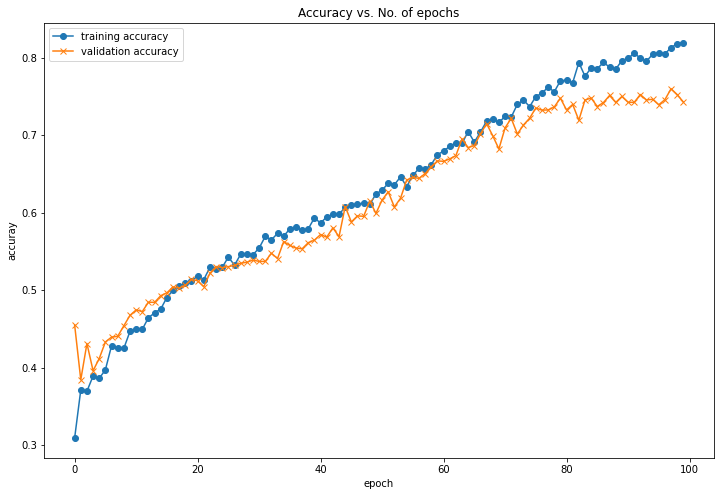

In [23]:
def plot_accuracies(history):

    train_accuracies = [x['train_acc'] for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize=(12, 8))
    plt.plot(train_accuracies, '-o', label='training accuracy')
    plt.plot(val_accuracies, '-x', label='validation accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuray')
    plt.title('Accuracy vs. No. of epochs')
    plt.legend()

plot_accuracies(history);

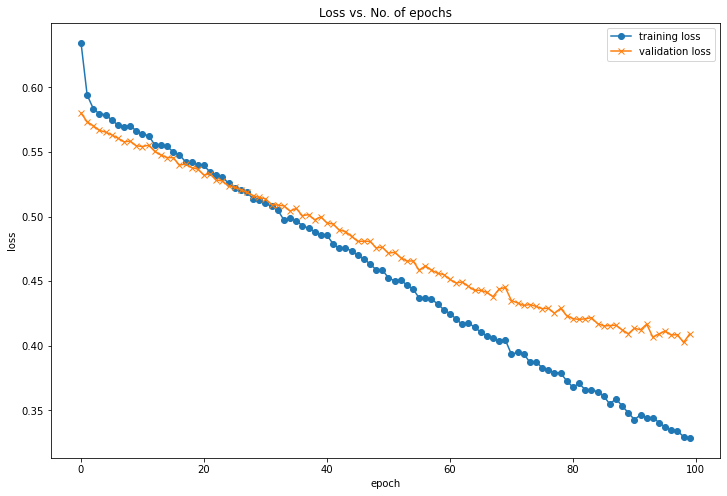

In [24]:
def plot_loss(history):

    train_accuracies = [x['train_loss'] for x in history]
    val_accuracies = [x['val_loss'] for x in history]
    plt.figure(figsize=(12, 8))
    plt.plot(train_accuracies, '-o', label='training loss')
    plt.plot(val_accuracies, '-x', label='validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')
    plt.legend()

plot_loss(history);

In [330]:
torch.save(model.state_dict(), "filename.pth")
print("model training and stored at filename.pth")

mdoel training and stored at filename.pth


# Scratch

In [54]:
dataiter = iter(train_dl)
images, labels = dataiter.next()
print (images[0].shape)

In [163]:
for images, labels in train_dl:
    print(torch.tensor(labels.clone().detach().requires_grad_(True), dtype=torch.long))
    break

tensor([[0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 1],
        [1, 0,

<ipython-input-163-15f5293c2acc>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(labels.clone().detach().requires_grad_(True), dtype=torch.long))


In [158]:
# Test the model on the first batch from the training dataloader
model=BirdSongModel()
for images, labels in train_dl:
    print(labels)
    print('images.shape:', images.shape)
#     out = model(images)
    print('labels.shape:', labels.shape)
#     print('out[0]:', out[0])
#     print('sum out[0]:', torch.sum(out[0]).item())

    break

tensor([[0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0., 0., 1

# CNN - Best Clips 2 seconds

In [25]:
X, y = load_images(dataset, path='mel_spectrograms_best_clip'), dataset['label'].to_numpy()
X.shape, y.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2371/2371 [00:02<00:00, 973.01it/s]


((2371, 128, 87), (2371,))

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

print(X_train.shape)
print(X_test.shape)

(1185, 128, 87)
(1186, 128, 87)


In [143]:
train_data = []
# Note: Conv2d layers expect input with the shape (n_samples, channels, height, width)
for i in range(len(X_train)):
    train_data.append([np.expand_dims(X_train[i], axis=0), y_train[i]]) 
test_data = []
for i in range(len(X_test)):
    test_data.append([np.expand_dims(X_test[i], axis=0), y_test[i]])

In [144]:
batch_size=50
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [145]:
class ImageClassifierBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        labels_c = torch.tensor(labels, dtype=torch.long, device=device)
        out = self(images)                  # Generate predictions
        # print('out:', out)
        # print('labels:', labels)
        # print('Start loss calc')
        # criterion=nn.BCELoss()
        # loss = criterion(out, labels.type(torch.float))  # Calculate loss
        criterion = nn.MultiLabelMarginLoss()
        loss = criterion(out, labels_c)
        acc = accuracy(out, labels)         # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        labels_c = torch.tensor(labels, dtype=torch.long, device=device)
        out = self(images)                  # Generate predictions
        # criterion=nn.BCELoss()
        # loss = criterion(out, labels.type(torch.float))   # Calculate loss
        criterion = nn.MultiLabelMarginLoss()
        loss = criterion(out, labels_c)
        acc = accuracy_val(out, labels.long())           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels, threshold=0.5):
    
    preds = np.array(outputs.cpu().detach().numpy() >= threshold, dtype=float)
    score = precision_score(labels.cpu().detach().numpy(), preds, average='micro')

    return torch.tensor(score)

def accuracy_val(outputs, labels, threshold=0.5):
    
    preds = np.array(outputs.cpu().numpy() >= threshold, dtype=float)
    score = precision_score(labels.cpu().numpy(), preds, average='samples')

    return torch.tensor(score)

In [146]:
# # Test image size
# simple_model = nn.Sequential(
#     nn.Conv2d(1, 8, kernel_size=2, stride=1, padding=0),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(8, 16, kernel_size=2, stride=1, padding=0),
#     nn.ReLU(),
#     nn.MaxPool2d(2),

#     nn.Conv2d(16, 32, kernel_size=1, stride=1, padding=0),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0),
#     nn.ReLU(),
#     nn.MaxPool2d(2),

# #     nn.Flatten(), 
# #     nn.Linear(256*3*7, 1024),
# #     nn.ReLU(),
# #     nn.Linear(1024, 5)
# )
# for images, labels in train_dl:
#     print('images.shape:', images.shape)
#     out = simple_model(images)
#     print('out.shape:', out.shape)
#     break

In [147]:
class BirdSongModel(ImageClassifierBase):
    def __init__(self):
        super().__init__()
        
        conv_layers = []

        self.conv1 = nn.Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
        self.relu1 = nn.ReLU()
#         self.bn1 = nn.GroupNorm(2, 8)
        nn.init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.pool1 = nn.MaxPool2d(2)
        conv_layers += [self.conv1, self.relu1, self.pool1]

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
        self.relu2 = nn.ReLU()
#         self.bn2 = nn.GroupNorm(4, 16)
        nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.pool2 = nn.MaxPool2d(2)
        conv_layers += [self.conv2, self.relu2, self.pool2]
        
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.relu3 = nn.ReLU()
        nn.init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.pool3 = nn.MaxPool2d(2)
        conv_layers += [self.conv3, self.relu3, self.pool3]

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.relu4 = nn.ReLU()
        nn.init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.pool4 = nn.MaxPool2d(2)
        conv_layers += [self.conv4, self.relu4, self.pool4]
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64*7*5, 50)
        self.relufc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(50, 10)
        self.relufc2 = nn.ReLU()
        self.linear3 = nn.Linear(10, 8)
        self.sigmoid = nn.Sigmoid()
        conv_layers += [self.flatten, self.linear1, self.relufc1, self.dropout,
                        self.linear2, self.relufc2, self.linear3, self.sigmoid]
        
        self.network = nn.Sequential(*conv_layers)
        

    def forward(self, x):

        return self.network(x)

In [148]:
# Helper functions to have option of running with GPU or CPU
def get_default_device():
    """Create device: Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) of data to chosen device"""
    # If list of tensors
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    # else if single tensor
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to yield data to device as
    the batches are requested"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [149]:
# Helper functions to fit and evaluate model
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracies = []
        for batch in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            # Calculate loss
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accuracies.append(acc)
            # Back-propogate loss
            loss.backward()
            # Update weights
            optimizer.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [150]:
device = get_default_device()
# print(device)
model = to_device(BirdSongModel(), device)

# Wrap training and test data loaders using `DeviceDataLoader` for automatically
# transferring batches of data to the GPU (if available), and use `to_device` 
# to move our model to the GPU (if available).
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

# evaluate(model, test_dl)

num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.00002

In [151]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [0], train_loss: 6.1516, train_acc: 0.2417, val_loss: 6.0267, val_acc: 0.2447


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [1], train_loss: 5.8586, train_acc: 0.2772, val_loss: 5.5941, val_acc: 0.2582


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [2], train_loss: 5.4757, train_acc: 0.2687, val_loss: 5.1834, val_acc: 0.2580


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [3], train_loss: 5.1043, train_acc: 0.2579, val_loss: 4.8020, val_acc: 0.2550


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [4], train_loss: 4.7690, train_acc: 0.2561, val_loss: 4.4488, val_acc: 0.2565


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to

Epoch [5], train_loss: 4.4793, train_acc: 0.2569, val_loss: 4.1285, val_acc: 0.2570


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [6], train_loss: 4.2163, train_acc: 0.2476, val_loss: 3.8511, val_acc: 0.2563


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [7], train_loss: 3.9561, train_acc: 0.2490, val_loss: 3.6027, val_acc: 0.2557


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended 

Epoch [8], train_loss: 3.7423, train_acc: 0.2470, val_loss: 3.3820, val_acc: 0.2574


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [9], train_loss: 3.5633, train_acc: 0.2452, val_loss: 3.1920, val_acc: 0.2565


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [10], train_loss: 3.4220, train_acc: 0.2487, val_loss: 3.0213, val_acc: 0.2574


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [11], train_loss: 3.2491, train_acc: 0.2492, val_loss: 2.8570, val_acc: 0.2576


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [12], train_loss: 3.0753, train_acc: 0.2531, val_loss: 2.6993, val_acc: 0.2587


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [13], train_loss: 2.9260, train_acc: 0.2544, val_loss: 2.5600, val_acc: 0.2572


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [14], train_loss: 2.7659, train_acc: 0.2536, val_loss: 2.4394, val_acc: 0.2580


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to

Epoch [15], train_loss: 2.6874, train_acc: 0.2573, val_loss: 2.3243, val_acc: 0.2565


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [16], train_loss: 2.5473, train_acc: 0.2603, val_loss: 2.2202, val_acc: 0.2557


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [17], train_loss: 2.4461, train_acc: 0.2604, val_loss: 2.1191, val_acc: 0.2782


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [18], train_loss: 2.3907, train_acc: 0.2563, val_loss: 2.0270, val_acc: 0.2832


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended t

Epoch [19], train_loss: 2.2447, train_acc: 0.2609, val_loss: 1.9408, val_acc: 0.2823


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [20], train_loss: 2.1773, train_acc: 0.2618, val_loss: 1.8583, val_acc: 0.2832


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [21], train_loss: 2.0807, train_acc: 0.2590, val_loss: 1.7861, val_acc: 0.2823


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [22], train_loss: 2.0017, train_acc: 0.2554, val_loss: 1.7236, val_acc: 0.2832


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [23], train_loss: 1.9217, train_acc: 0.2563, val_loss: 1.6664, val_acc: 0.2832


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [24], train_loss: 1.8432, train_acc: 0.2462, val_loss: 1.6125, val_acc: 0.2835


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [25], train_loss: 1.7420, train_acc: 0.2529, val_loss: 1.5264, val_acc: 0.2852


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [26], train_loss: 1.6719, train_acc: 0.2531, val_loss: 1.4298, val_acc: 0.2832


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [27], train_loss: 1.5831, train_acc: 0.2470, val_loss: 1.3386, val_acc: 0.2829


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [28], train_loss: 1.5177, train_acc: 0.2427, val_loss: 1.2305, val_acc: 0.2809


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [29], train_loss: 1.4638, train_acc: 0.2410, val_loss: 1.1216, val_acc: 0.2823


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [30], train_loss: 1.3430, train_acc: 0.2294, val_loss: 1.0163, val_acc: 0.1468


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended t

Epoch [31], train_loss: 1.2718, train_acc: 0.2316, val_loss: 0.9209, val_acc: 0.1426


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [32], train_loss: 1.2210, train_acc: 0.2245, val_loss: 0.8342, val_acc: 0.1409


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to

Epoch [33], train_loss: 1.1775, train_acc: 0.2158, val_loss: 0.7522, val_acc: 0.1426


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [34], train_loss: 1.1253, train_acc: 0.2168, val_loss: 0.6777, val_acc: 0.1426


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [35], train_loss: 1.0249, train_acc: 0.2073, val_loss: 0.6034, val_acc: 0.1417


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [36], train_loss: 0.9704, train_acc: 0.2037, val_loss: 0.5397, val_acc: 0.1422


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [37], train_loss: 0.9310, train_acc: 0.1985, val_loss: 0.4797, val_acc: 0.1409


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to

Epoch [38], train_loss: 0.8963, train_acc: 0.1961, val_loss: 0.4292, val_acc: 0.1417


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [39], train_loss: 0.8473, train_acc: 0.1954, val_loss: 0.3838, val_acc: 0.1400


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [40], train_loss: 0.7384, train_acc: 0.1841, val_loss: 0.3471, val_acc: 0.1426


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [41], train_loss: 0.7180, train_acc: 0.1937, val_loss: 0.3176, val_acc: 0.1422


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [42], train_loss: 0.7046, train_acc: 0.1859, val_loss: 0.2878, val_acc: 0.1430


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [43], train_loss: 0.6717, train_acc: 0.1863, val_loss: 0.2594, val_acc: 0.1430


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [44], train_loss: 0.6122, train_acc: 0.1808, val_loss: 0.2318, val_acc: 0.1430


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [45], train_loss: 0.5704, train_acc: 0.1797, val_loss: 0.2112, val_acc: 0.1426


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [46], train_loss: 0.5412, train_acc: 0.1803, val_loss: 0.1871, val_acc: 0.1413


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended t

Epoch [47], train_loss: 0.5197, train_acc: 0.1784, val_loss: 0.1557, val_acc: 0.1426


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [48], train_loss: 0.4949, train_acc: 0.1769, val_loss: 0.1314, val_acc: 0.1426


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [49], train_loss: 0.4486, train_acc: 0.1775, val_loss: 0.1092, val_acc: 0.1413


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [50], train_loss: 0.4222, train_acc: 0.1733, val_loss: 0.0889, val_acc: 0.1422


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [51], train_loss: 0.4261, train_acc: 0.1748, val_loss: 0.0727, val_acc: 0.1417


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [52], train_loss: 0.3716, train_acc: 0.1720, val_loss: 0.0613, val_acc: 0.1422


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [53], train_loss: 0.3543, train_acc: 0.1667, val_loss: 0.0530, val_acc: 0.1430


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [54], train_loss: 0.3514, train_acc: 0.1739, val_loss: 0.0452, val_acc: 0.1426


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [55], train_loss: 0.3045, train_acc: 0.1743, val_loss: 0.0388, val_acc: 0.1426


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [56], train_loss: 0.3044, train_acc: 0.1647, val_loss: 0.0338, val_acc: 0.1422


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [57], train_loss: 0.2655, train_acc: 0.1682, val_loss: 0.0296, val_acc: 0.1430


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [58], train_loss: 0.2549, train_acc: 0.1656, val_loss: 0.0260, val_acc: 0.1430


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended 

Epoch [59], train_loss: 0.2519, train_acc: 0.1619, val_loss: 0.0225, val_acc: 0.1417


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [60], train_loss: 0.2540, train_acc: 0.1622, val_loss: 0.0205, val_acc: 0.1426


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [61], train_loss: 0.2178, train_acc: 0.1610, val_loss: 0.0179, val_acc: 0.1430


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [62], train_loss: 0.2234, train_acc: 0.1621, val_loss: 0.0157, val_acc: 0.1435


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [63], train_loss: 0.1985, train_acc: 0.1588, val_loss: 0.0138, val_acc: 0.1430


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended t

Epoch [64], train_loss: 0.1985, train_acc: 0.1600, val_loss: 0.0123, val_acc: 0.1435


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [65], train_loss: 0.1912, train_acc: 0.1589, val_loss: 0.0110, val_acc: 0.1404


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [66], train_loss: 0.2048, train_acc: 0.1583, val_loss: 0.0099, val_acc: 0.1417


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [67], train_loss: 0.1489, train_acc: 0.1601, val_loss: 0.0088, val_acc: 0.1448


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [68], train_loss: 0.1564, train_acc: 0.1594, val_loss: 0.0078, val_acc: 0.1435


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [69], train_loss: 0.1408, train_acc: 0.1577, val_loss: 0.0070, val_acc: 0.1409


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [70], train_loss: 0.1485, train_acc: 0.1595, val_loss: 0.0063, val_acc: 0.1413


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [71], train_loss: 0.1275, train_acc: 0.1559, val_loss: 0.0057, val_acc: 0.1413


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [72], train_loss: 0.1326, train_acc: 0.1548, val_loss: 0.0051, val_acc: 0.1422


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [73], train_loss: 0.1290, train_acc: 0.1564, val_loss: 0.0047, val_acc: 0.1409


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [74], train_loss: 0.1275, train_acc: 0.1554, val_loss: 0.0043, val_acc: 0.1430


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [75], train_loss: 0.1098, train_acc: 0.1553, val_loss: 0.0039, val_acc: 0.1417


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to

Epoch [76], train_loss: 0.1051, train_acc: 0.1555, val_loss: 0.0035, val_acc: 0.1417


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [77], train_loss: 0.1047, train_acc: 0.1550, val_loss: 0.0032, val_acc: 0.1422


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [78], train_loss: 0.1121, train_acc: 0.1532, val_loss: 0.0029, val_acc: 0.1443


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [79], train_loss: 0.0919, train_acc: 0.1537, val_loss: 0.0027, val_acc: 0.1413


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [80], train_loss: 0.1148, train_acc: 0.1546, val_loss: 0.0025, val_acc: 0.1417


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to

Epoch [81], train_loss: 0.0947, train_acc: 0.1539, val_loss: 0.0023, val_acc: 0.1422


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [82], train_loss: 0.0774, train_acc: 0.1533, val_loss: 0.0021, val_acc: 0.1413


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [83], train_loss: 0.0862, train_acc: 0.1529, val_loss: 0.0019, val_acc: 0.1400


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [84], train_loss: 0.0879, train_acc: 0.1548, val_loss: 0.0017, val_acc: 0.1387


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [85], train_loss: 0.0919, train_acc: 0.1538, val_loss: 0.0016, val_acc: 0.1422


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [86], train_loss: 0.0941, train_acc: 0.1527, val_loss: 0.0014, val_acc: 0.1426


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [87], train_loss: 0.0898, train_acc: 0.1506, val_loss: 0.0013, val_acc: 0.1404


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [88], train_loss: 0.0770, train_acc: 0.1522, val_loss: 0.0013, val_acc: 0.1422


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended 

Epoch [89], train_loss: 0.0676, train_acc: 0.1531, val_loss: 0.0011, val_acc: 0.1435


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [90], train_loss: 0.0729, train_acc: 0.1543, val_loss: 0.0011, val_acc: 0.1413


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [91], train_loss: 0.0643, train_acc: 0.1535, val_loss: 0.0010, val_acc: 0.1426


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [92], train_loss: 0.0735, train_acc: 0.1526, val_loss: 0.0009, val_acc: 0.1422


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [93], train_loss: 0.0598, train_acc: 0.1512, val_loss: 0.0008, val_acc: 0.1413


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [94], train_loss: 0.0583, train_acc: 0.1503, val_loss: 0.0008, val_acc: 0.1422


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

Epoch [95], train_loss: 0.0677, train_acc: 0.1520, val_loss: 0.0007, val_acc: 0.1417


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [96], train_loss: 0.0587, train_acc: 0.1518, val_loss: 0.0007, val_acc: 0.1439


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [97], train_loss: 0.0515, train_acc: 0.1535, val_loss: 0.0006, val_acc: 0.1417


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [98], train_loss: 0.0568, train_acc: 0.1534, val_loss: 0.0006, val_acc: 0.1404


<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:4: UserWarning: To copy construct from a tensor, it is recommended to 

<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_c = torch.tensor(labels, dtype=torch.long, device=device)
<ipython-input-145-bf85edfdce52>:18: UserWarning: To copy construct from a tensor, it is recommended

Epoch [99], train_loss: 0.0610, train_acc: 0.1553, val_loss: 0.0005, val_acc: 0.1439


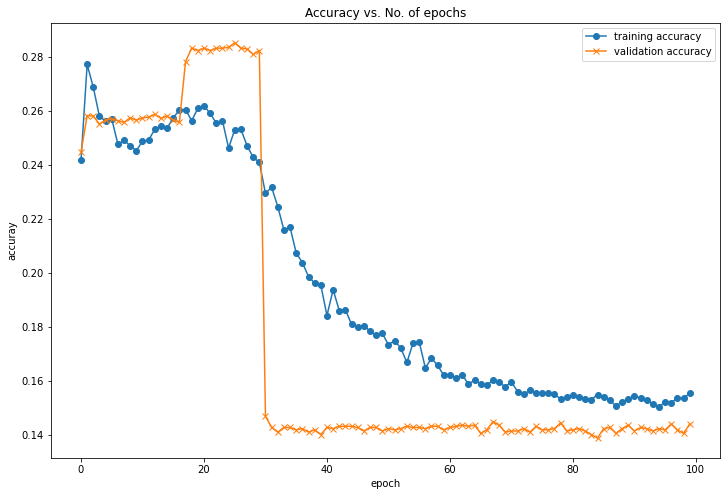

In [152]:
plot_accuracies(history);

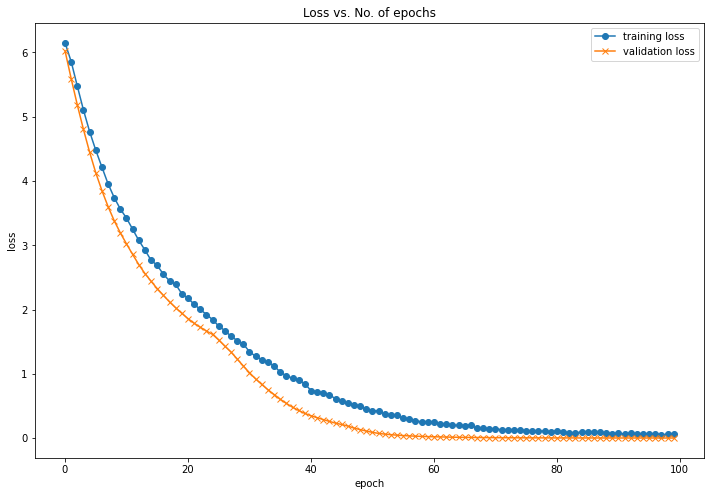

In [153]:
plot_loss(history);